# **Computer Vision Model - Base Case**

**Objective**: Implement a base case CNN to detect one of the 6 findings in a chest x-ray from mimiciv radiology images selected by the team for the Capstone project

**Data**: Train, validate and test set of images have been created and stored on the team google drive (`Download` links: [images](?) and [labels](?)). For the base case, the smaller samples set will be used to train the model. Even a sub_sample data set was created for the initial testing of the algorithm.

# 1. Installation & Packages Setup 
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

In [1]:
#!pip install pydot

In [2]:
#!apt-get install graphviz -y

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

In [3]:
# standard
import pandas as pd
import numpy as np
import random
import os
np.random.seed(711)     #recommended to place this command before importing keras

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.backend import epsilon
from keras import models
from keras import layers
tf.random.set_seed(711)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# plots
import seaborn as sns
import matplotlib.pyplot as plt

#random.seed(711)
%matplotlib inline

2024-03-05 04:40:58.660881: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 04:40:58.684760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 04:40:58.684787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 04:40:58.685518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 04:40:58.690253: I tensorflow/core/platform/cpu_feature_guar

---

# 2. Define Constants & Methods
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

In [4]:
# Define image directories
local_base_dir = '/tf/mount/0 Berkeley/0 Spring 2024/w210 Capstone/Project/mimic_data/mimic_images'
latest_processed_file = 'Processed_Image_Data_Feb_28_2024.csv'
latest_file_path = os.path.join(local_base_dir, latest_processed_file)

# 3. Load Meta Data & Create Model DataSets
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

Read previously saved and latest processed image meta file

In [5]:
# Read the CSV file into a dataframe
data = pd.read_csv(latest_file_path)

# Use patient_id as the index
data.set_index('patient_id', inplace=True)

print(data.info())
data.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 16877 entries, 19998562 to 15032392
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   study_id                                    16877 non-null  int64  
 1   atelectasis                                 16877 non-null  float64
 2   cardiomegaly                                16877 non-null  float64
 3   edema                                       16877 non-null  float64
 4   lung_opacity                                16877 non-null  float64
 5   pleural_effusion                            16877 non-null  float64
 6   pneumonia                                   16877 non-null  float64
 7   data_type                                   16877 non-null  object 
 8   is_sample                                   16877 non-null  bool   
 9   dicom_id                                    16877 non-null  object 
 10  Perfo

,study_id,atelectasis,cardiomegaly,edema,lung_opacity,pleural_effusion,pneumonia,data_type,is_sample,dicom_id,...,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,jpg_filename,anomaly,all_zeros,set
patient_id,,,,,,,,,,,,,,,,,,,,,
19998562,52252154,0.0,0.0,0.0,0.0,1.0,0.0,test,False,e3e5f8c3-14429887-b1181522-445ec3a8-110663c3,...,2544,21660321,224219.015,CHEST (PA AND LAT),postero-anterior,Erect,https://physionet.org/files/mimic-cxr-jpg/2.0....,1,False,1
13831580,55371824,0.0,0.0,0.0,0.0,0.0,0.0,test,False,f34f44ce-0feade9a-8a71da5b-6e080e42-643cb41d,...,2544,22031114,210815.687,CHEST (PA AND LAT),postero-anterior,Erect,https://physionet.org/files/mimic-cxr-jpg/2.0....,1,True,1


Add the '.jpg' extension to 'dicom_id" values

In [6]:
# Append '.jpg' to each filename in the dicom_id column for all X dataframes
data['dicom_id'] = data['dicom_id'].apply(lambda x: x + '.jpg')

Create train, validate & test data sets

In [7]:
# Create separate dataframes for train, validate, and test
train = data[data['data_type'] == 'train']
validate = data[data['data_type'] == 'validate']
test = data[data['data_type'] == 'test']

# Create separate dataframes for sample_train, sample_validate, and sample_test
sample_train = train[train['is_sample'] == True]
sample_validate = validate[validate['is_sample'] == True]
sample_test = test[test['is_sample'] == True]

# Split each dataframe into X (features; in this case the image file name) and y (labels)
# Define columns for X and y
X_columns = ['dicom_id']
y_columns = ['atelectasis', 'cardiomegaly', 'edema', 'lung_opacity', 'pleural_effusion', 'pneumonia']

# Split for train
X_train = train[X_columns]
y_train = train[y_columns]

# Split for validate
X_validate = validate[X_columns]
y_validate = validate[y_columns]

# Split for test
X_test = test[X_columns]
y_test = test[y_columns]

# Split for sample train
X_sample_train = sample_train[X_columns]
y_sample_train = sample_train[y_columns]

# Split for sample validate
X_sample_validate = sample_validate[X_columns]
y_sample_validate = sample_validate[y_columns]

# Split for sample test
X_sample_test = sample_test[X_columns]
y_sample_test = sample_test[y_columns]

# Split for sample train
X_sample_train = sample_train[X_columns]
y_sample_train = sample_train[y_columns]

# Split for sample validate
X_sample_validate = sample_validate[X_columns]
y_sample_validate = sample_validate[y_columns]

# Split for sample test
X_sample_test = sample_test[X_columns]
y_sample_test = sample_test[y_columns]

Create an additional sub_sample data set for initial trial of model

In [8]:
# Function to check if any disease is present
def any_disease_present(row):
    return (row > 0).any().astype(int)

# Apply the function to create a new column for simplified stratification
# Ensure you're working on a copy to avoid SettingWithCopyWarning
y_sample_train = y_sample_train.copy()
y_sample_validate = y_sample_validate.copy()
y_sample_test = y_sample_test.copy()

y_sample_train['any_disease'] = y_sample_train.apply(any_disease_present, axis=1)
y_sample_validate['any_disease'] = y_sample_validate.apply(any_disease_present, axis=1)
y_sample_test['any_disease'] = y_sample_test.apply(any_disease_present, axis=1)

# Define a function for creating stratified subsets
def create_stratified_subset(X, y, stratify_col, subset_size=0.1):
    _, X_sub, _, y_sub = train_test_split(X, y, test_size=subset_size, stratify=y[stratify_col], random_state=711)
    return X_sub, y_sub.drop(columns=[stratify_col])

# Create stratified subsets based on the presence of any disease
X_sub_sample_train, y_sub_sample_train = create_stratified_subset(X_sample_train, y_sample_train, 'any_disease', 0.1)
X_sub_sample_validate, y_sub_sample_validate = create_stratified_subset(X_sample_validate, y_sample_validate, 'any_disease', 0.1)
X_sub_sample_test, y_sub_sample_test = create_stratified_subset(X_sample_test, y_sample_test, 'any_disease', 0.1)

Verify results

In [9]:
# Create a dictionary to hold all the X and Y dataframes
dataframes = {
    'X_train': X_train,
    'y_train': y_train,
    'X_validate': X_validate,
    'y_validate': y_validate,
    'X_test': X_test,
    'y_test': y_test,
    'X_sample_train': X_sample_train,
    'y_sample_train': y_sample_train,
    'X_sample_validate': X_sample_validate,
    'y_sample_validate': y_sample_validate,
    'X_sample_test': X_sample_test,
    'y_sample_test': y_sample_test,
    'X_sub_sample_train': X_sub_sample_train,
    'y_sub_sample_train': y_sub_sample_train,
    'X_sub_sample_validate': X_sub_sample_validate,
    'y_sub_sample_validate': y_sub_sample_validate,
    'X_sub_sample_test': X_sub_sample_test,
    'y_sub_sample_test': y_sub_sample_test
}

# Loop through the dictionary and print out the shapes
for name, df in dataframes.items():
    print(f"{name} shape: {df.shape}")

X_train shape: (11249, 1)
y_train shape: (11249, 6)
X_validate shape: (2814, 1)
y_validate shape: (2814, 6)
X_test shape: (2814, 1)
y_test shape: (2814, 6)
X_sample_train shape: (1124, 1)
y_sample_train shape: (1124, 7)
X_sample_validate shape: (282, 1)
y_sample_validate shape: (282, 7)
X_sample_test shape: (282, 1)
y_sample_test shape: (282, 7)
X_sub_sample_train shape: (113, 1)
y_sub_sample_train shape: (113, 6)
X_sub_sample_validate shape: (29, 1)
y_sub_sample_validate shape: (29, 6)
X_sub_sample_test shape: (29, 1)
y_sub_sample_test shape: (29, 6)


Check imbalance of labels

In [10]:
# Define the list of labels
labels = ['atelectasis', 'cardiomegaly', 'edema', 'lung_opacity', 'pleural_effusion', 'pneumonia']

def calculate_percentages(y_df):
    percentages = []
    for label in labels:
        positive_cases = y_df[label].sum()
        total_cases = len(y_df)
        percentage = (positive_cases / total_cases) * 100
        percentages.append(percentage)
    all_zeros_percentage = ((y_df[labels] == 0).all(axis=1).sum() / total_cases) * 100
    percentages.append(all_zeros_percentage)
    return percentages

def calculate_counts(y_df):
    counts = []
    for label in labels:
        positive_cases = y_df[label].sum()
        counts.append(positive_cases)
    all_zeros_count = (y_df[labels] == 0).all(axis=1).sum()
    counts.append(all_zeros_count)
    return counts

# List of datasets and their names
datasets = {
    'Train': y_train,
    'Validate': y_validate,
    'Test': y_test,
    'S Train': y_sample_train,
    'S Val': y_sample_validate,
    'S Test': y_sample_test,
    'Sub S Train': y_sub_sample_train,
    'Sub S Val': y_sub_sample_validate,
    'Sub S Test': y_sub_sample_test
}

# Calculate percentages and counts for all datasets
percentages = {name: calculate_percentages(df) for name, df in datasets.items()}
counts = {name: calculate_counts(df) for name, df in datasets.items()}

# Convert to DataFrames
percentages_df = pd.DataFrame(percentages, index=labels+['All Zeros']).style.format('{:.2f}%')
counts_df = pd.DataFrame(counts, index=labels+['All Zeros']).astype(int)  # Ensure counts are integers

# Display the styled DataFrame for percentages
print("Percentages:")
display(percentages_df)

# Display the DataFrame for counts
print("Counts:")
display(counts_df)

Percentages:


,Train,Validate,Test,S Train,S Val,S Test,Sub S Train,Sub S Val,Sub S Test
atelectasis,12.88%,12.86%,12.90%,11.92%,13.12%,14.54%,14.16%,13.79%,13.79%
cardiomegaly,10.06%,9.91%,10.13%,11.12%,9.93%,9.22%,9.73%,6.90%,10.34%
edema,8.24%,8.21%,8.24%,7.83%,7.09%,7.80%,6.19%,10.34%,6.90%
lung_opacity,19.45%,19.40%,19.51%,20.28%,20.21%,19.50%,21.24%,17.24%,10.34%
pleural_effusion,12.26%,12.26%,12.26%,10.77%,12.41%,9.22%,8.85%,20.69%,6.90%
pneumonia,6.53%,6.54%,6.50%,6.67%,7.80%,4.96%,8.85%,6.90%,6.90%
All Zeros,54.97%,55.01%,54.94%,55.25%,55.32%,57.09%,54.87%,55.17%,58.62%


Counts:


,Train,Validate,Test,S Train,S Val,S Test,Sub S Train,Sub S Val,Sub S Test
atelectasis,1449,362,363,134,37,41,16,4,4
cardiomegaly,1132,279,285,125,28,26,11,2,3
edema,927,231,232,88,20,22,7,3,2
lung_opacity,2188,546,549,228,57,55,24,5,3
pleural_effusion,1379,345,345,121,35,26,10,6,2
pneumonia,735,184,183,75,22,14,10,2,2
All Zeros,6184,1548,1546,621,156,161,62,16,17


## Discussion:
The percentages shown above indicate a significant imbalance in the dataset. When the positive instances for a label constitute a small fraction of the total (as is the case here, with values ranging between approximately 6% and 20%), it suggests that the dataset is heavily skewed towards negative instances (in this case, the absence of a particular condition).

Moreover, the fact that 54.97% of our records have all labels set to zero (meaning no conditions are present) further emphasizes this imbalance. This can pose challenges for our machine learning models, as it might become biased towards predicting the negative class due to its higher prevalence in the training data.

To address this imbalance, especially if it manifests itself during testing, we might consider undersampling the majority class or applying different weights to the classes during model training to penalize misclassification of the minority class more heavily.

---

# 4. Inspect Available Images
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

Sample of images in sample train dataset:


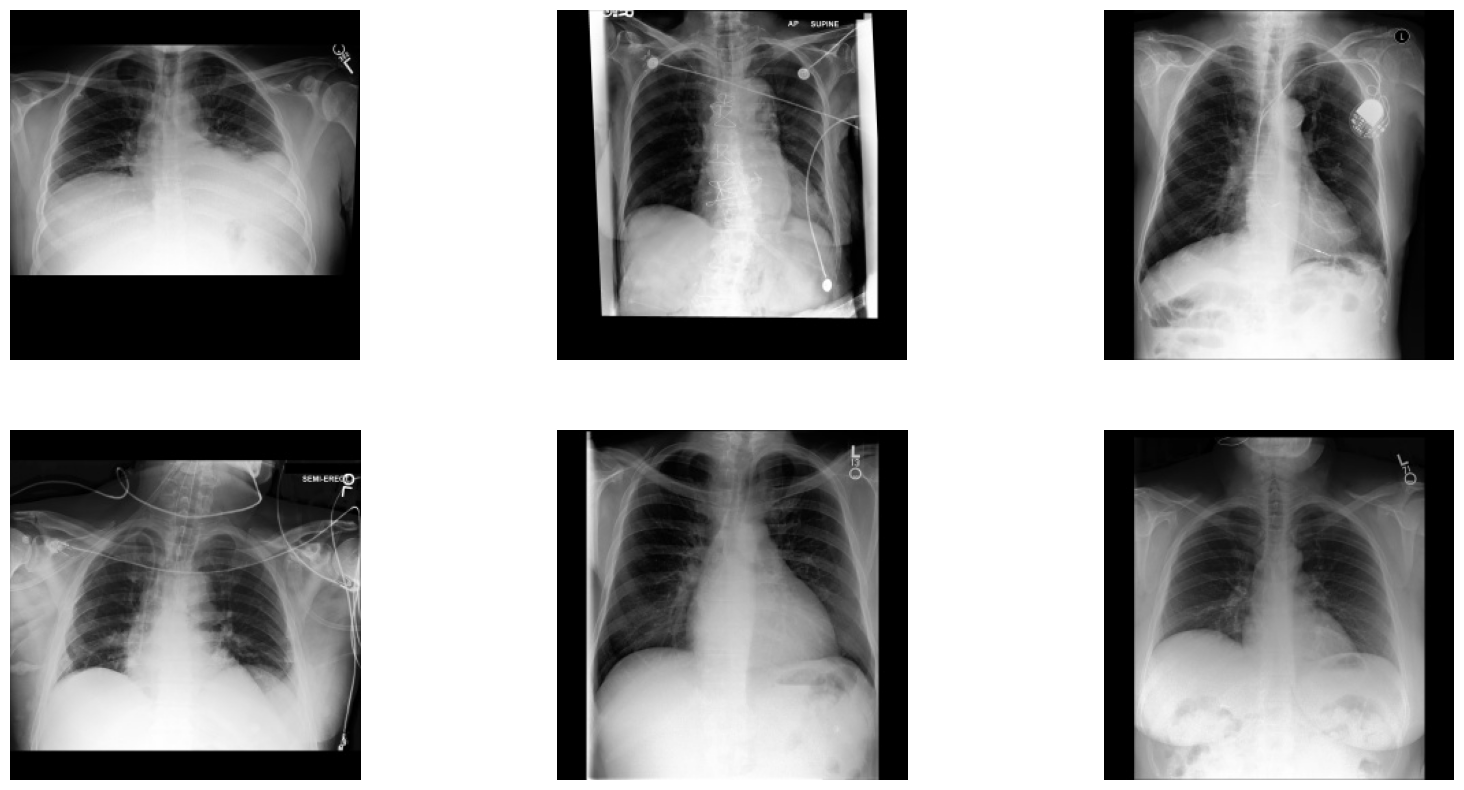

In [11]:
# Define the subdirectory for train images
train_images_dir = 'size_256/sample_images_256/sample_train_images_256'   #  Using the 512x512 directory

# Construct the full path to the train images directory
images_path = os.path.join(local_base_dir, train_images_dir)

# Initialize variables
images = []
print('Sample of images in sample train dataset:')

# Load the first 8 images
for idx, img_file in enumerate(os.listdir(images_path)):
    if idx < 6:  # Only process the first 6 images
        img = load_img(os.path.join(images_path, img_file))
        images.append(img)
    else:
        break  # Stop the loop after the first 6 images

# Set up the subplot dimensions
nrows, ncols = 2, 3  
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

# Display the images
for i in range(nrows):
    for j in range(ncols):
        indx = i * ncols + j  # Correct calculation of index
        if indx < len(images):  # Check to avoid IndexError
            axs[i, j].imshow(images[indx])
            axs[i, j].axis('off')  # Remove axes

plt.show()

---

# 5. Image Normalization & Data Generation
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

## 5.1 Choice of Samples Set
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

In [12]:
# Select samples to be used: for now let's use the sub_sample set to test the algorithm 
sample_directory = os.path.join(local_base_dir, 'size_256/sample_images_256')
select_train_dir = 'sample_train_images_256'
select_val_dir   = 'sample_validate_images_256'
select_test_dir  = 'sample_test_images_256'
target_size = 256
X_trn = X_sample_train
y_trn = y_sample_train
X_val = X_sample_validate
y_val = y_sample_validate
X_test = X_sample_test
y_test = y_sample_test

## 5.2 Generate Image Data
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

In [13]:
# Create the image data generator function 
def prepare_data_generators(X_train, y_train, X_val, y_val, X_test, y_test, train_dir, val_dir, test_dir, target_size=256):
    # Create ImageDataGenerator instances with normalization
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen   = ImageDataGenerator(rescale=1./255)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train.join(y_train),
        directory=train_dir,
        x_col='dicom_id',
        y_col=['atelectasis', 'cardiomegaly', 'edema', 'lung_opacity', 'pleural_effusion', 'pneumonia'],
        target_size=(target_size, target_size),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=711
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=X_val.join(y_val),
        directory=val_dir,
        x_col='dicom_id',
        y_col=['atelectasis', 'cardiomegaly', 'edema', 'lung_opacity', 'pleural_effusion', 'pneumonia'],
        target_size=(target_size, target_size),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=False,
        seed=711
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=X_test.join(y_test),
        directory=test_dir,
        x_col='dicom_id',
        y_col=['atelectasis', 'cardiomegaly', 'edema', 'lung_opacity', 'pleural_effusion', 'pneumonia'],
        target_size=(target_size, target_size),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=False,
        seed=711
    )

    return train_generator, val_generator, test_generator

In [14]:
# Generate the image data
train_generator, val_generator, test_generator = prepare_data_generators(
    X_trn, y_trn, 
    X_val, y_val, 
    X_test, y_test, 
    os.path.join(sample_directory, select_train_dir), 
    os.path.join(sample_directory, select_val_dir), 
    os.path.join(sample_directory, select_test_dir),
    target_size = target_size
)

Found 1124 validated image filenames.
Found 282 validated image filenames.
Found 282 validated image filenames.


In [15]:
# Fetch a single batch from the train_generator
x_batch, y_batch = next(train_generator)

# Print the shape of the batch
print("Shape of x_batch:", x_batch.shape)
print("Shape of y_batch:", y_batch.shape)

Shape of x_batch: (32, 256, 256, 3)
Shape of y_batch: (32, 6)


# 6. Model
<div style="float:left; font-size:0.7em;"><a href="#returnToTop">Return to Top</a></div> <a id='setup'></a>

## 6.1 Build Custom 'f1 score' Function

In [17]:
# Define the custom metric class
class ExtendedMultiLabelMetrics(tf.keras.metrics.Metric):
    def __init__(self, num_labels, name='extended_multi_label_metrics', **kwargs):
        super(ExtendedMultiLabelMetrics, self).__init__(name=name, **kwargs)
        self.num_labels = num_labels
        self.precision = [tf.keras.metrics.Precision(name=f'precision_{i}') for i in range(num_labels)]
        self.recall = [tf.keras.metrics.Recall(name=f'recall_{i}') for i in range(num_labels)]
        self.auc = [tf.keras.metrics.AUC(name=f'auc_{i}') for i in range(num_labels)]
        self.f1_scores = [self.add_weight(name=f'f1_score_{i}', initializer='zeros') for i in range(num_labels)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_labels):
            self.precision[i].update_state(y_true[:, i], y_pred[:, i])
            self.recall[i].update_state(y_true[:, i], y_pred[:, i])
            self.auc[i].update_state(y_true[:, i], y_pred[:, i])
            p = self.precision[i].result()
            r = self.recall[i].result()
            self.f1_scores[i].assign(2 * ((p * r) / (p + r + tf.keras.backend.epsilon())))

    def result(self):
        # Return both individual and average metrics
        metrics = {}
        for i in range(self.num_labels):
            metrics[f'precision_{i}'] = self.precision[i].result()
            metrics[f'recall_{i}'] = self.recall[i].result()
            metrics[f'auc_{i}'] = self.auc[i].result()
            metrics[f'f1_score_{i}'] = self.f1_scores[i]

        metrics['avg_f1_score'] = tf.reduce_mean(self.f1_scores)
        metrics['avg_precision'] = tf.reduce_mean([p.result() for p in self.precision])
        metrics['avg_recall'] = tf.reduce_mean([r.result() for r in self.recall])
        metrics['avg_auc'] = tf.reduce_mean([auc.result() for auc in self.auc])
        return metrics

    def reset_state(self):
        for i in range(self.num_labels):
            self.precision[i].reset_state()
            self.recall[i].reset_state()
            self.auc[i].reset_state()
            self.f1_scores[i].assign(0)

## 6.2 Build Model

In [18]:
n_classes = 6        # number of classes/labels (pathologial findings)
shape_size = 256

# Initialize the extended multi-label metrics class
extended_multi_label_metrics = ExtendedMultiLabelMetrics(num_labels=n_classes)

# Clear any previous session to free memory
clear_session()

model = tf.keras.Sequential()

# add first convolution layer
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    input_shape=(shape_size, shape_size, 3)))

# First max pooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # this will reduce the spatial dimensions by half

# Second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu'))

# Second max pooling layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Flatten the output to feed into a fully connected layer
model.add(tf.keras.layers.Flatten())

# Fully connected layer with 1024 units
model.add(tf.keras.layers.Dense(units=256, activation='relu'))    # attempt to avoid memory issues (change from: units = 1024)

# Dropout layer for regularization
model.add(tf.keras.layers.Dropout(rate=0.25))

# Output layer with 'n_classes' units and sigmoid activation function for multi-label classification
model.add(tf.keras.layers.Dense(units=n_classes, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[extended_multi_label_metrics]
             )

# Print model summary
model.summary()

# Plot the model
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

2024-03-05 04:41:10.586732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 04:41:10.591404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 04:41:10.591426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 04:41:10.593971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 04:41:10.593990: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               1

## 6.3 Fit Model

In [19]:
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


2024-03-05 04:41:14.352790: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-05 04:41:15.685045: I external/local_xla/xla/service/service.cc:168] XLA service 0xb2111e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 04:41:15.685072: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-05 04:41:15.688488: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709613675.738414   24911 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 12s 178ms/step - loss: 0.4154 - precision_0: 0.0000e+00 - recall_0: 0.0000e+00 - auc_0: 0.4637 - f1_score_0: 0.0000e+00 - precision_1: 0.1276 - recall_1: 0.0634 - auc_1: 0.5357 - f1_score_1: 0.0666 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.5878 - f1_score_2: 0.0000e+00 - precision_3: 0.1135 - recall_3: 0.0349 - auc_3: 0.4554 - f1_score_3: 0.0472 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.4647 - f1_score_4: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.4118 - f1_score_5: 0.0000e+00 - avg_f1_score: 0.0190 - avg_precision: 0.0402 - avg_recall: 0.0164 - avg_auc: 0.4865 - val_loss: 0.3550 - val_precision_0: 0.0000e+00 - val_recall_0: 0.0000e+00 - val_auc_0: 0.5723 - val_f1_score_0: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.6486 - val_f1_score_1: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.6010 - val_f1_score_2: 0

## 6.4 Save Model

In [20]:
# Save the model for later use
# model.save('model_samples256_256x20_k3-3_Dp1.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

## 6.5 Inspect Results

In [21]:
# Print all keys in the history object
print(history.history.keys())

dict_keys(['loss', 'precision_0', 'recall_0', 'auc_0', 'f1_score_0', 'precision_1', 'recall_1', 'auc_1', 'f1_score_1', 'precision_2', 'recall_2', 'auc_2', 'f1_score_2', 'precision_3', 'recall_3', 'auc_3', 'f1_score_3', 'precision_4', 'recall_4', 'auc_4', 'f1_score_4', 'precision_5', 'recall_5', 'auc_5', 'f1_score_5', 'avg_f1_score', 'avg_precision', 'avg_recall', 'avg_auc', 'val_loss', 'val_precision_0', 'val_recall_0', 'val_auc_0', 'val_f1_score_0', 'val_precision_1', 'val_recall_1', 'val_auc_1', 'val_f1_score_1', 'val_precision_2', 'val_recall_2', 'val_auc_2', 'val_f1_score_2', 'val_precision_3', 'val_recall_3', 'val_auc_3', 'val_f1_score_3', 'val_precision_4', 'val_recall_4', 'val_auc_4', 'val_f1_score_4', 'val_precision_5', 'val_recall_5', 'val_auc_5', 'val_f1_score_5', 'val_avg_f1_score', 'val_avg_precision', 'val_avg_recall', 'val_avg_auc'])


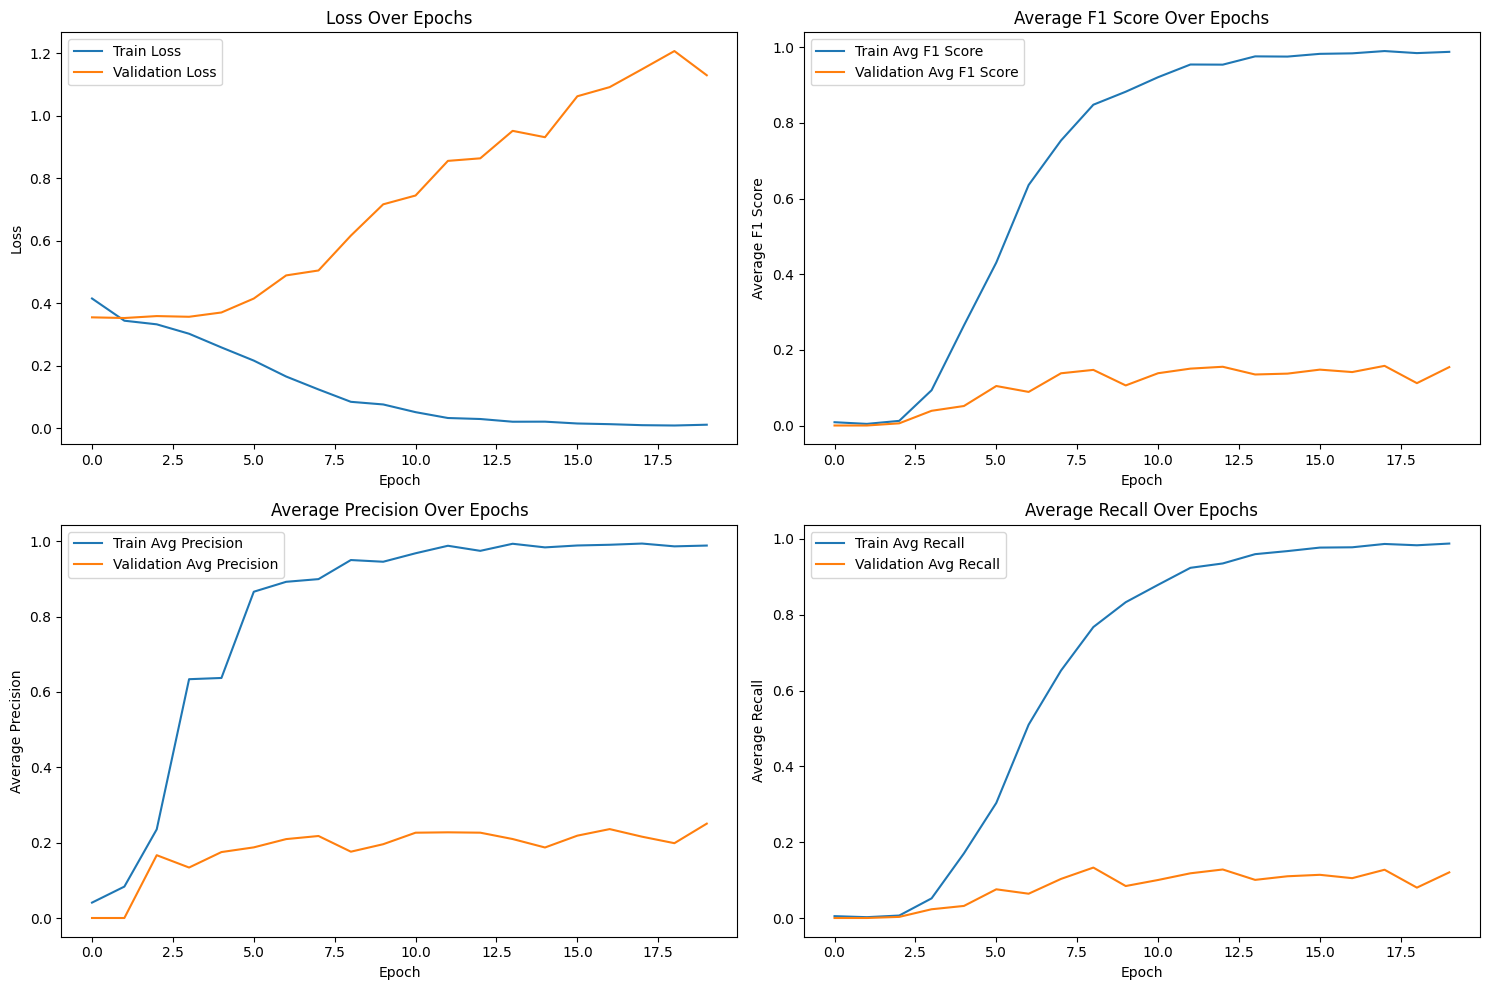

In [22]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss Over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot Average F1 Score
    axes[0, 1].plot(history.history['avg_f1_score'], label='Train Avg F1 Score')
    axes[0, 1].plot(history.history['val_avg_f1_score'], label='Validation Avg F1 Score')
    axes[0, 1].set_title('Average F1 Score Over Epochs')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Average F1 Score')
    axes[0, 1].legend()

    # Plot Average Precision
    axes[1, 0].plot(history.history['avg_precision'], label='Train Avg Precision')
    axes[1, 0].plot(history.history['val_avg_precision'], label='Validation Avg Precision')
    axes[1, 0].set_title('Average Precision Over Epochs')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Average Precision')
    axes[1, 0].legend()

    # Plot Average Recall
    axes[1, 1].plot(history.history['avg_recall'], label='Train Avg Recall')
    axes[1, 1].plot(history.history['val_avg_recall'], label='Validation Avg Recall')
    axes[1, 1].set_title('Average Recall Over Epochs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Average Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 6.6 Test Model

In [23]:
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Binarize predictions with a threshold of 0.5
predictions_binarized = (predictions > 0.5).astype(int)

# Ensure 'true_labels' is properly defined; it should be an array of shape (num_samples, num_labels)
# If 'y_test' is a DataFrame, you can convert it to a NumPy array using 'y_test.values'
true_labels = y_test.values

9/9 [==============================] - 3s 389ms/step


## 6.7 Plot Results

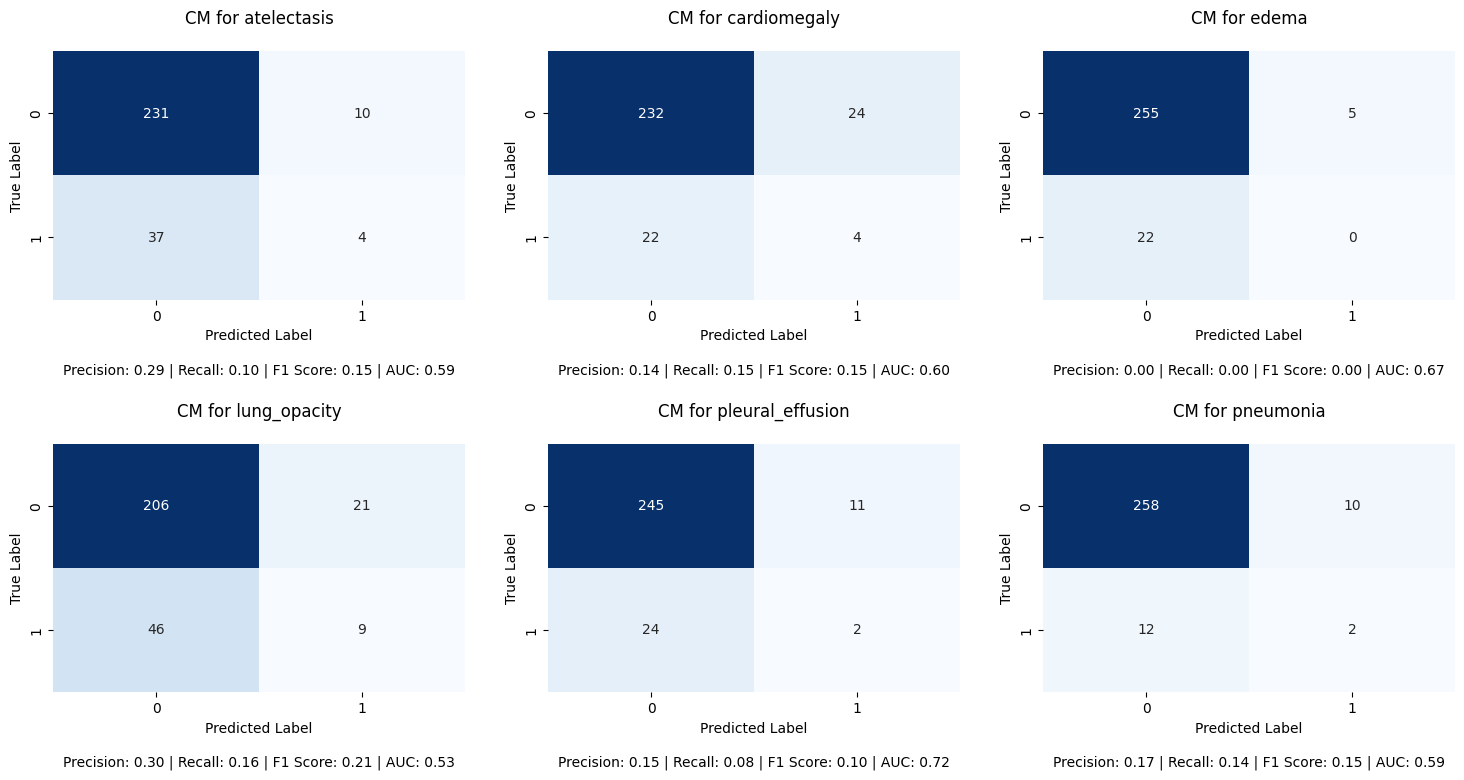

Average Precision: 0.17
Average Recall: 0.11
Average F1 Score: 0.13
Average AUC: 0.62


In [26]:
# Initialize variables to accumulate scores
total_precision = 0
total_recall = 0
total_f1 = 0
total_auc = 0

# Determine the number of rows needed for subplots (3 CMs per row)
num_labels = len(y_columns)
num_rows = int(np.ceil(num_labels / 3))

# Create a figure for subplots
plt.figure(figsize=(15, num_rows * 4))  # Width increased for 3 CMs per row, height adjusted for better aspect ratio

# Plot confusion matrices for each label and calculate metrics
for i, label in enumerate(y_columns):
    ax = plt.subplot(num_rows, 3, i + 1)  # Create subplot for each CM
    
    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels[:, i], predictions_binarized[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)  # cbar=False to hide the color bar
    ax.set_title(f'CM for {label}', pad=20)  # Increase padding to separate title from metrics
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    
    # Calculate individual metrics
    precision = precision_score(true_labels[:, i], predictions_binarized[:, i], zero_division=0)
    recall = recall_score(true_labels[:, i], predictions_binarized[:, i], zero_division=0)
    f1 = f1_score(true_labels[:, i], predictions_binarized[:, i], zero_division=0)
    auc = roc_auc_score(true_labels[:, i], predictions[:, i])  # Use non-binarized predictions for AUC

    # Accumulate to compute average
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_auc += auc

    # Display individual metrics below each CM
    ax.text(0.5, -0.3, f'Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f} | AUC: {auc:.2f}', 
            ha='center', transform=ax.transAxes, fontsize=10)  # Adjusted fontsize and positioning

# Adjust layout to prevent overlap and show the plot with all CMs
plt.tight_layout()
plt.show()

# Calculate and print average metrics after displaying all CMs
avg_precision = total_precision / len(y_columns)
avg_recall = total_recall / len(y_columns)
avg_f1 = total_f1 / len(y_columns)
avg_auc = total_auc / len(y_columns)
print(f'Average Precision: {avg_precision:.2f}')
print(f'Average Recall: {avg_recall:.2f}')
print(f'Average F1 Score: {avg_f1:.2f}')
print(f'Average AUC: {avg_auc:.2f}')

---